<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.EEG_Tensorflow_models/blob/main/Experimental/Preprocessing_MI/Preprocessing_BCICIV2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Importan Modules

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils > /dev/null
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases > /dev/null #Module for database reading.
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.filters.git > /dev/null #Module for filters
!pip install mne > /dev/null #The MNE library is installed
FILEID = "1O2Iiam5QVaHQFd2t_pWmDpmPUP_0pNyV"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt > /dev/null
!unzip MI_EEG_ClassMeth.zip > /dev/null #Package with useful functions for motor imagery classification based in EEG.
!dir

  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.utils /tmp/pip-req-build-lsd9bxp8
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-_elsxqrn
  Running command git clone -q https://github.com/UN-GCPDS/python-gcpds.filters.git /tmp/pip-req-build-kqqckcrw
--2021-11-08 15:12:26--  https://docs.google.com/uc?export=download&confirm=&id=1O2Iiam5QVaHQFd2t_pWmDpmPUP_0pNyV
Resolving docs.google.com (docs.google.com)... 173.194.217.113, 173.194.217.138, 173.194.217.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-bk-docs.googleusercontent.com/docs/securesc/30ckta7bknkgi0kt3cker95n6i1lskv1/4tr31c1j8ut8mp1ai30mmt57vpk3866p/1636384275000/09711457892284675029/07033108602856203522Z/1O2Iiam5QVaHQFd2t_pWmDpmPUP_0pNyV?e=download [following]
--2021-11-08 15:12:26--  https://doc-00-bk-docs.googleusercont

# Import Modules

In [ ]:
import os 
import numpy as np
from gcpds.utils import colab
import gcpds.databases as loaddb
from gcpds.filters import frequency as flt
from mne.channels import make_standard_montage
from mne import create_info
from mne import EpochsArray
from mne.preprocessing import compute_current_source_density
from MI_EEG_ClassMeth.Preprocessing import ICA
from MI_EEG_ClassMeth.FeatExtraction import GaussianKernel, SpectralConnectivity
from MI_EEG_ClassMeth.MIfunctions import Window_band_CSP_eppoch, flatt
from MI_EEG_ClassMeth.utils import grid_search_info
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pickle import load, dump
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Mount Drive

In [ ]:
colab.mount()

Mounted at /content/drive


#Functions

In [ ]:
def read_results(info, mode='CV/', type_exp='Preprocessing', subjects=np.arange(9)+1):
  if mode == 'CV/':
    res = np.zeros((len(info['sbj1']['no_ICA-no_surface_laplacian']['test_metrics']), len(info['sbj1']['no_ICA-no_surface_laplacian']['test_metrics'][0]) ,len(info.keys())))
    if type_exp == 'No_Preprocessing':
      for id_sbj, sbj in enumerate(subjects):
        res[:,:,id_sbj] = np.round(np.array(info['sbj'+str(sbj)]['no_ICA-no_surface_laplacian']['test_metrics'])*100, 1)
    elif type_exp == 'Preprocessing':
      for id_sbj, sbj in enumerate(subjects):
        best_steps = info['sbj'+str(sbj)]['best_steps']
        res[:,:,id_sbj] = np.round(np.array(info['sbj'+str(sbj)][best_steps[0]+'-'+best_steps[1]]['test_metrics'])*100, 1)
    else:
      raise ValueError('No valid type_exp')
  elif mode == 'test/':
    if type_exp == 'No_Preprocessing':
      res = np.round(np.array(info['No_Preprocessing'])*100,1).T
    elif type_exp == 'Preprocessing':
      res = np.round(np.array(info['Preprocessing'])*100,1).T
    else:
      raise ValueError('No valid type_exp')
  else:
    raise ValueError('No valid mode')
  return res

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

# Tests

In [ ]:
parent_dir = './drive/Shareddrives/GCPDS/users/Mateo/BCICIV2a/'

## Bi-Class

In [ ]:
cross_val_dir = os.path.join(parent_dir,'CV/Bi-Class/')
test_dir = os.path.join(parent_dir,'test/Bi-Class/')
model_dir = os.path.join(parent_dir,'Models/Bi-Class/')
images_dir = os.path.join(parent_dir,'Images/Bi-Class/')
try:
  os.makedirs(cross_val_dir)
  os.makedirs(test_dir)
  os.makedirs(model_dir)
  os.makedirs(images_dir)
except FileExistsError:
  pass

### GFC

In [ ]:
model_dir_no_prep = os.path.join(model_dir ,'GFC/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'GFC/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass

#### CV

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(np.arange(9)+1):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
    else:
      Xica = X_mi[:,:len(EEG_channels),:]
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(Xslap) #GFC
      classifier = LDA()
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':'precision' ,'recall':'recall', 'f1_score':'f1' ,'auc':'roc_auc'}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xgk, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'GFC.txt', 'wb'))

100%|██████████| 9/9 [06:23<00:00, 42.58s/it]


#### Test

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high

##### No_preprocessing

In [ ]:
no_prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_no_prep+'/subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #no-preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements (test)
  X_mi = bandps_filter(X[:,:len(EEG_channels),int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(X_mi) #GFC
  y_pred = model.predict(Xgk)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, model.predict_proba(Xgk)[:, 1])
  no_prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [07:41<00:00, 51.24s/it]


##### Preprocessing

In [ ]:
with open(cross_val_dir + 'GFC.txt', 'rb') as fcv:
    cv_info = load(fcv) #Load CV info

In [ ]:
prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_prep+'subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements (test)
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  ICA_flag, slap_flag = cv_info['sbj'+str(sbj)]['best_steps']
  if ICA_flag == 'ICA':
    Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
  else:
    Xica = X_mi[:,:len(EEG_channels),:]
  if slap_flag == 'surface_laplacian':
    EpochsXica = EpochsArray(Xica, info)
    EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
    Xslap = EpochsXsl.get_data()
  else:
    Xslap = Xica
  Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(Xslap) #GFC
  y_pred = model.predict(Xgk)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, model.predict_proba(Xgk)[:, 1])
  prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [02:18<00:00, 15.40s/it]


##### Save Results

In [ ]:
dump({'No_Preprocessing':no_prep_test_result ,'Preprocessing':prep_test_result}, open(test_dir + 'GFC.txt', 'wb'))

### COH

In [ ]:
model_dir_no_prep = os.path.join(model_dir ,'COH/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'COH/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass

#### CV

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(np.arange(9)+1):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
    else:
      Xica = X_mi[:,:len(EEG_channels),:]
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=3).fit_transform(Xslap) #COH
      classifier = LDA()
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':'precision' ,'recall':'recall', 'f1_score':'f1' ,'auc':'roc_auc'}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xcoh, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'COH.txt', 'wb'))

100%|██████████| 9/9 [14:23<00:00, 95.91s/it]


#### Test

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high

##### No_preprocessing

In [ ]:
no_prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_no_prep+'/subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #no-preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements (test)
  X_mi = bandps_filter(X[:,:len(EEG_channels),int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=3).fit_transform(X_mi) #COH
  y_pred = model.predict(Xcoh)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, model.predict_proba(Xcoh)[:, 1])
  no_prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [01:40<00:00, 11.14s/it]


##### Preprocessing

In [ ]:
with open(cross_val_dir + 'COH.txt', 'rb') as fcv:
    cv_info = load(fcv) #Load CV info

In [ ]:
prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_prep+'subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements (test)
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  ICA_flag, slap_flag = cv_info['sbj'+str(sbj)]['best_steps']
  if ICA_flag == 'ICA':
    Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
  else:
    Xica = X_mi[:,:len(EEG_channels),:]
  if slap_flag == 'surface_laplacian':
    EpochsXica = EpochsArray(Xica, info)
    EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
    Xslap = EpochsXsl.get_data()
  else:
    Xslap = Xica
  Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=3).fit_transform(Xslap) #COH
  y_pred = model.predict(Xcoh)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, model.predict_proba(Xcoh)[:, 1])
  prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [03:17<00:00, 21.98s/it]


##### Save Results

In [ ]:
dump({'No_Preprocessing':no_prep_test_result ,'Preprocessing':prep_test_result}, open(test_dir + 'COH.txt', 'wb'))

### CSP

In [ ]:
model_dir_no_prep = os.path.join(model_dir ,'CSP/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'CSP/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass

#### CV

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(np.arange(9)+1):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
    else:
      Xica = X_mi[:,:len(EEG_channels),:]
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      steps = [('CSP', Window_band_CSP_eppoch(fs=sfreq, f_frec=f_bank, vtw=np.array([[0,3]]), ncomp=6, reg='shrinkage')),
               ('flat',flatt()),
               ('cla', LDA())]
      classifier = Pipeline(steps)
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':'precision' ,'recall':'recall', 'f1_score':'f1' ,'auc':'roc_auc'}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xslap, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'CSP.txt', 'wb'))

100%|██████████| 9/9 [18:17<00:00, 121.97s/it]


#### Test

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high

##### No_preprocessing

In [ ]:
no_prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_no_prep+'/subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #no-preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements (test)
  X_mi = bandps_filter(X[:,:len(EEG_channels),int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  y_pred = model.predict(X_mi)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, model.predict_proba(X_mi)[:, 1])
  no_prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [00:31<00:00,  3.52s/it]


##### Preprocessing

In [ ]:
with open(cross_val_dir + 'CSP.txt', 'rb') as fcv:
    cv_info = load(fcv) #Load CV info

In [ ]:
prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_prep+'subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data(classes=['left hand', 'right hand']) #Load data of left and right hand movements (test)
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  ICA_flag, slap_flag = cv_info['sbj'+str(sbj)]['best_steps']
  if ICA_flag == 'ICA':
    Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
  else:
    Xica = X_mi[:,:len(EEG_channels),:]
  if slap_flag == 'surface_laplacian':
    EpochsXica = EpochsArray(Xica, info)
    EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
    Xslap = EpochsXsl.get_data()
  else:
    Xslap = Xica
  y_pred = model.predict(Xslap)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, model.predict_proba(Xslap)[:, 1])
  prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [01:33<00:00, 10.37s/it]


##### Save Results

In [ ]:
dump({'No_Preprocessing':no_prep_test_result ,'Preprocessing':prep_test_result}, open(test_dir + 'CSP.txt', 'wb'))

### Read results

#### Form for latex table

In [ ]:
evaluation_mode = ['CV/', 'test/']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
type_representation = ['COH', 'GFC', 'CSP']
n_subjects = 9
results_row = []

for id_eval_mode, eval_mode in enumerate(evaluation_mode): 
  for id_type_prep, type_prep in enumerate(type_preprocessing):
    results_col = []
    for id_m, m in enumerate(metrics):
      for type_rep in type_representation:
        with open(parent_dir + eval_mode + 'Bi-Class/' + type_rep + '.txt', 'rb') as feval:
            eval_info = load(feval) #Load CV info
        metric_sbj = np.zeros(n_subjects)
        for sbj in np.arange(n_subjects)+1:
          if eval_mode == 'CV/':
            if type_prep == 'No_Preprocessing':
              metric_sbj[sbj-1] = np.round(eval_info['sbj'+str(sbj)]['no_ICA'+'-'+'no_surface_laplacian']['test_metrics'][0][id_m]*100,1)
            else: 
              best_steps = eval_info['sbj'+str(sbj)]['best_steps']
              metric_sbj[sbj-1] = np.round(eval_info['sbj'+str(sbj)][best_steps[0]+'-'+best_steps[1]]['test_metrics'][0][id_m]*100,1)
          else:
            if type_prep == 'No_Preprocessing':
              metric_sbj[sbj-1] = np.round(eval_info['No_Preprocessing'][sbj-1][id_m]*100,1)
            else: 
              metric_sbj[sbj-1] = np.round(eval_info['Preprocessing'][sbj-1][id_m]*100,1)
        results_col.append(str(np.round(metric_sbj.mean(),1))+' \pm '+str(np.round(metric_sbj.std(),1)))
    results_row.append(results_col)

In [ ]:
for j in range(len(results_row[0])):
  for i in range(len(results_row)):
    print('&$'+results_row[i][j]+'$',end='')
  print(r'\\')

&$64.6 \pm 10.1$&$66.0 \pm 9.4$&$65.0 \pm 10.2$&$63.6 \pm 8.6$\\
&$71.3 \pm 12.6$&$75.9 \pm 12.0$&$72.9 \pm 9.1$&$73.0 \pm 10.3$\\
&$69.7 \pm 11.4$&$75.8 \pm 10.8$&$72.4 \pm 13.0$&$76.0 \pm 11.4$\\
&$66.0 \pm 10.2$&$67.4 \pm 9.8$&$64.6 \pm 12.4$&$62.0 \pm 8.3$\\
&$72.7 \pm 12.3$&$77.8 \pm 12.2$&$70.6 \pm 8.8$&$72.4 \pm 11.5$\\
&$71.6 \pm 11.2$&$77.2 \pm 9.9$&$72.1 \pm 12.8$&$74.5 \pm 12.0$\\
&$64.6 \pm 11.3$&$67.4 \pm 10.1$&$71.9 \pm 18.1$&$76.6 \pm 14.4$\\
&$71.5 \pm 13.4$&$75.8 \pm 12.7$&$78.7 \pm 10.9$&$78.6 \pm 12.7$\\
&$71.8 \pm 11.2$&$77.1 \pm 12.0$&$73.7 \pm 23.7$&$79.6 \pm 17.4$\\
&$64.0 \pm 10.3$&$66.0 \pm 9.6$&$66.6 \pm 11.1$&$67.5 \pm 7.4$\\
&$71.0 \pm 13.2$&$75.4 \pm 12.8$&$74.2 \pm 8.9$&$74.4 \pm 8.7$\\
&$70.3 \pm 11.0$&$75.9 \pm 11.1$&$71.0 \pm 17.1$&$76.1 \pm 13.2$\\
&$68.9 \pm 12.2$&$69.7 \pm 11.6$&$70.5 \pm 12.9$&$69.0 \pm 12.1$\\
&$76.9 \pm 13.3$&$80.1 \pm 14.0$&$79.9 \pm 11.3$&$81.2 \pm 11.8$\\
&$75.3 \pm 13.9$&$81.7 \pm 12.8$&$80.6 \pm 14.3$&$82.3 \pm 13.5$\\


#### Graphs

##### Graph 1

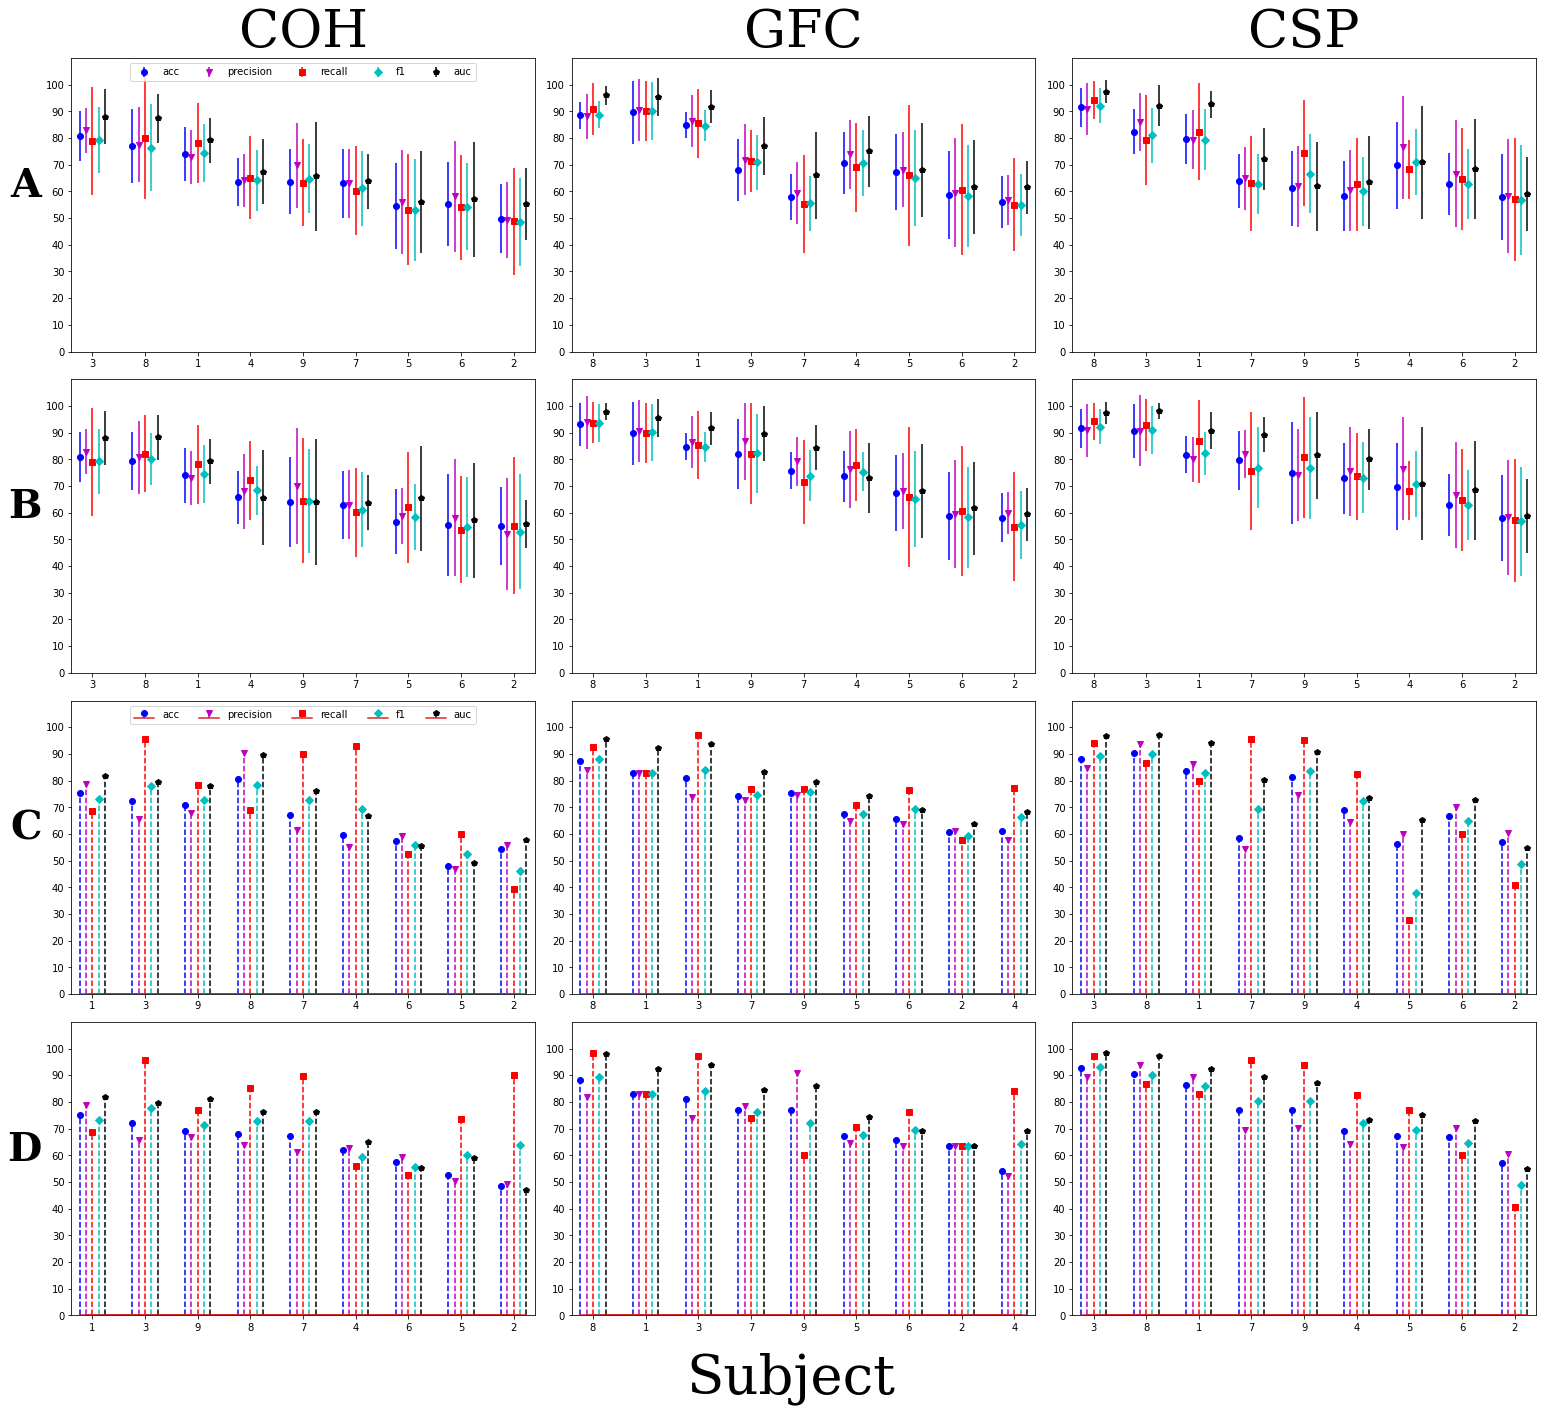

In [ ]:
evaluation_mode = ['CV/', 'test/']
type_representation = ['COH', 'GFC', 'CSP']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
subjects = np.arange(9)+1
xseed = np.array([-0.6, -0.3, 0, 0.3, 0.6])
markers = ['o', 'v', 's', 'D', 'p']
colors = ['b', 'm','r', 'c', 'k']
fig, axs = plt.subplots(len(evaluation_mode)*len(type_preprocessing), len(type_representation), figsize=(21,18), squeeze=False)

for id_eval_mode, eval_mode in zip([0,2], evaluation_mode):
  for id_type_rep, type_rep in enumerate(type_representation):
    with open(parent_dir + eval_mode + 'Bi-Class/' + type_rep + '.txt', 'rb') as feval:
      eval_info = load(feval) #Load CV info
    if eval_mode == 'CV/':
      sbjs_order = np.argsort(read_results(eval_info, mode=eval_mode, type_exp='Preprocessing', subjects=subjects)[0,0,:])[::-1]
    else:
      sbjs_order = np.argsort(read_results(eval_info, mode=eval_mode, type_exp='Preprocessing', subjects=subjects)[0,:])[::-1]
    for id_type_prep, type_prep in enumerate(type_preprocessing):
      sbjs_metrics = read_results(eval_info, mode=eval_mode, type_exp=type_prep, subjects=subjects)
      for id_m, m in enumerate(metrics):
        if eval_mode == 'CV/':
          axs[id_type_prep+id_eval_mode, id_type_rep].errorbar(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[0,id_m,sbjs_order], yerr=sbjs_metrics[1,id_m,sbjs_order], fmt=markers[id_m], color=colors[id_m], label=m)
        else:
          axs[id_type_prep+id_eval_mode, id_type_rep].stem(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[id_m,sbjs_order], linefmt='--'+colors[id_m], markerfmt=markers[id_m]+colors[id_m], label=m)
      if eval_mode == 'CV/':
        #axs[id_type_prep+id_eval_mode, id_type_rep].legend(loc='lower left', ncol=1)
        axs[id_type_prep+id_eval_mode, id_type_rep].set_ylim([0, 110])
      else:
        #axs[id_type_prep+id_eval_mode, id_type_rep].legend(loc='upper right', ncol=1)
        axs[id_type_prep+id_eval_mode, id_type_rep].set_ylim([0, 110])
      axs[id_type_prep+id_eval_mode, id_type_rep].set_yticks(np.arange(0, 110, 10))
      axs[id_type_prep+id_eval_mode, id_type_rep].set_xticks(np.arange(0, subjects.shape[0]*2.5, 2.5))
      axs[id_type_prep+id_eval_mode, id_type_rep].set_xlim([-1, (subjects.shape[0]-1)*2.5+1])
      axs[id_type_prep+id_eval_mode, id_type_rep].set_xticklabels(subjects[sbjs_order])
  axs[0, 0].legend(loc='upper center', ncol=5)
  axs[2, 0].legend(loc='upper center', ncol=5)

fig.tight_layout()
axs[0, 0].set_title('COH', fontfamily='serif', fontsize=52.5, weight=500)
axs[0, 1].set_title('GFC', fontfamily='serif', fontsize=52.5, weight=500)
axs[0, 2].set_title('CSP', fontfamily='serif', fontsize=52.5, weight=500)

axs[0, 0].set_ylabel('A', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')
axs[1, 0].set_ylabel('B', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')
axs[2, 0].set_ylabel('C', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')
axs[3, 0].set_ylabel('D', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')

fig.text(0.5, axs[-1,-1].get_position().y0 - 0.06, 'Subject', ha='center', fontfamily='serif', fontsize=54.5, weight=500)
plt.savefig(images_dir+'metrics-subjects-bi-class.pdf',format='pdf', bbox_inches='tight')

##### Graph 2

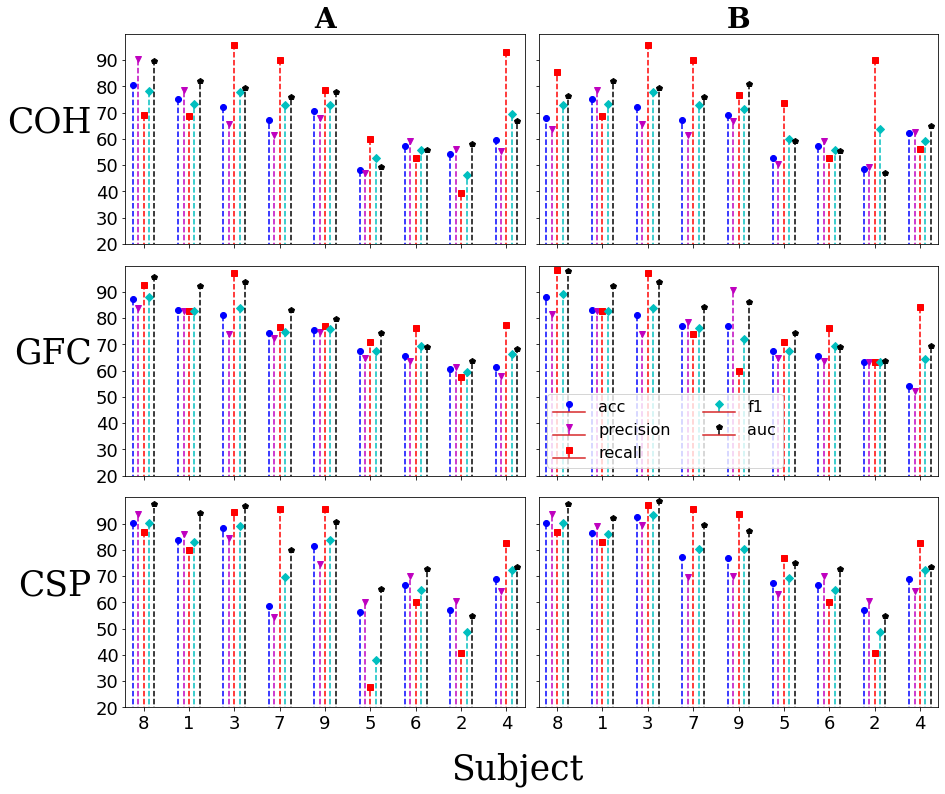

In [ ]:
type_feat_extraction = ['COH', 'GFC', 'CSP']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
subjects = np.arange(9)+1
min = np.inf
max = -np.inf
xseed = np.array([-0.6, -0.3, 0, 0.3, 0.6])
markers = ['o', 'v', 's', 'D', 'p']
colors = ['b', 'm','r', 'c', 'k']
fig, axs = plt.subplots(len(type_feat_extraction), len(type_preprocessing), figsize=(12,10), squeeze=False, sharex=True, sharey=True)

with open(test_dir + 'GFC.txt', 'rb') as feval:
  eval_info = load(feval) #Load test info
sbjs_order = np.argsort(read_results(eval_info, mode='test/', type_exp='Preprocessing', subjects=subjects)[0,:])[::-1]

for id_type_fte, type_fte in enumerate(type_feat_extraction):
  with open(test_dir + type_fte + '.txt', 'rb') as feval:
    eval_info = load(feval) #Load test info
  for id_type_prep, type_prep in enumerate(type_preprocessing):
    sbjs_metrics = read_results(eval_info, mode='test/', type_exp=type_prep, subjects=subjects)
    if sbjs_metrics.min() < min:
      min = sbjs_metrics.min()
    if sbjs_metrics.max() > max:
      max = sbjs_metrics.max()
    for id_m, m in enumerate(metrics):
      axs[id_type_fte, id_type_prep].stem(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[id_m,sbjs_order], linefmt='--'+colors[id_m], markerfmt=markers[id_m]+colors[id_m], label=m)
      
for j in range(axs.shape[1]):
  axs[-1,j].set_xticks(np.arange(0, subjects.shape[0]*2.5, 2.5))
  axs[-1,j].set_xticklabels(subjects[sbjs_order], fontsize=18)
  axs[-1,j].set_xlim([-1, (subjects.shape[0]-1)*2.5+1])

#Becareful with the order
for i in range(axs.shape[0]):
  axs[i,0].set_ylim([rounddown(min), roundup(max)])

for i in range(axs.shape[0]):
  axs[i,0].set_yticks(np.arange(rounddown(min), roundup(max), 10, dtype=np.int))
  axs[i,0].set_yticklabels(np.arange(rounddown(min), roundup(max), 10, dtype=np.int), fontsize=18)

axs[1,1].legend(loc='lower left', fontsize=16, ncol=2)

fig.tight_layout()
axs[0, 0].set_ylabel('COH', fontfamily='serif', fontsize=34.5, weight=500, rotation=0, ha='right')
axs[1, 0].set_ylabel('GFC', fontfamily='serif', fontsize=34.5, weight=500, rotation=0, ha='right')
axs[2, 0].set_ylabel('CSP', fontfamily='serif', fontsize=34.5, weight=500, rotation=0, ha='right')

axs[0, 0].set_title('A', fontfamily='serif', fontsize=28, weight=1000)
axs[0, 1].set_title('B', fontfamily='serif', fontsize=28, weight=1000)

fig.text(0.5, axs[-1,-1].get_position().y0 - 0.1, 'Subject', ha='center', fontfamily='serif', fontsize=34.5, weight=500)
plt.savefig(images_dir+'metrics-subjects-bi-class.pdf',format='pdf', bbox_inches='tight')

## Multi-Class

In [ ]:
cross_val_dir = os.path.join(parent_dir,'CV/Multi-Class/')
test_dir = os.path.join(parent_dir,'test/Multi-Class/')
model_dir = os.path.join(parent_dir,'Models/Multi-Class/')
images_dir = os.path.join(parent_dir,'Images/Multi-Class/')
try:
  os.makedirs(cross_val_dir)
  os.makedirs(test_dir)
  os.makedirs(model_dir)
  os.makedirs(images_dir)
except FileExistsError:
  pass

### GFC

In [ ]:
model_dir_no_prep = os.path.join(model_dir ,'GFC/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'GFC/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass

#### CV

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(np.arange(9)+1):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data() #Load data of all motor imagery tasks
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
    else:
      Xica = X_mi[:,:len(EEG_channels),:]
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(Xslap) #GFC
      classifier = LDA(solver='lsqr', shrinkage='auto')
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':make_scorer(precision_score, average='macro') ,'recall':make_scorer(recall_score, average='macro'), 'f1_score':make_scorer(f1_score, average='macro') ,'auc':make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xgk, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'GFC.txt', 'wb'))

100%|██████████| 9/9 [14:50<00:00, 98.91s/it]


#### Test

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high

##### No_preprocessing

In [ ]:
no_prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_no_prep+'/subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #no-preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data() #Load data of all motor imagery tasks (test)
  X_mi = bandps_filter(X[:,:len(EEG_channels),int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(X_mi) #GFC
  y_pred = model.predict(Xgk)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  auc = roc_auc_score(y_test, model.predict_proba(Xgk), multi_class='ovr')
  no_prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [05:28<00:00, 36.46s/it]


##### Preprocessing

In [ ]:
with open(cross_val_dir + 'GFC.txt', 'rb') as fcv:
    cv_info = load(fcv) #Load CV info

In [ ]:
prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_prep+'subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data() #Load data of all motor imagery tasks (test)
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  ICA_flag, slap_flag = cv_info['sbj'+str(sbj)]['best_steps']
  if ICA_flag == 'ICA':
    Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
  else:
    Xica = X_mi[:,:len(EEG_channels),:]
  if slap_flag == 'surface_laplacian':
    EpochsXica = EpochsArray(Xica, info)
    EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
    Xslap = EpochsXsl.get_data()
  else:
    Xslap = Xica
  Xgk = GaussianKernel(sfreq=sfreq, f_bank=f_bank).fit_transform(Xslap) #GFC
  y_pred = model.predict(Xgk)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  auc = roc_auc_score(y_test, model.predict_proba(Xgk), multi_class='ovr')
  prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [05:21<00:00, 35.70s/it]


##### Save Results

In [ ]:
dump({'No_Preprocessing':no_prep_test_result ,'Preprocessing':prep_test_result}, open(test_dir + 'GFC.txt', 'wb'))

### COH

In [ ]:
model_dir_no_prep = os.path.join(model_dir ,'COH/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'COH/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass

#### CV

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(np.arange(9)+1):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data() #Load data of all motor imagery tasks
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
    else:
      Xica = X_mi[:,:len(EEG_channels),:]
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=3).fit_transform(Xslap) #COH
      classifier = LDA(solver='lsqr', shrinkage='auto')
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':make_scorer(precision_score, average='macro') ,'recall':make_scorer(recall_score, average='macro'), 'f1_score':make_scorer(f1_score, average='macro') ,'auc':make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xcoh, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'COH.txt', 'wb'))

100%|██████████| 9/9 [26:17<00:00, 175.25s/it]


#### Test

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high

##### No_preprocessing

In [ ]:
no_prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_no_prep+'/subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #no-preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data() #Load data of all motor imagery tasks (test)
  X_mi = bandps_filter(X[:,:len(EEG_channels),int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=3).fit_transform(X_mi) #COH
  y_pred = model.predict(Xcoh)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  auc = roc_auc_score(y_test, model.predict_proba(Xcoh), multi_class='ovr')
  no_prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [04:27<00:00, 29.70s/it]


##### Preprocessing

In [ ]:
with open(cross_val_dir + 'COH.txt', 'rb') as fcv:
    cv_info = load(fcv) #Load CV info

In [ ]:
prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_prep+'subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data() #Load data of all motor imagery tasks (test)
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  ICA_flag, slap_flag = cv_info['sbj'+str(sbj)]['best_steps']
  if ICA_flag == 'ICA':
    Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
  else:
    Xica = X_mi[:,:len(EEG_channels),:]
  if slap_flag == 'surface_laplacian':
    EpochsXica = EpochsArray(Xica, info)
    EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
    Xslap = EpochsXsl.get_data()
  else:
    Xslap = Xica
  Xcoh = SpectralConnectivity(sfreq=sfreq, f_bank=f_bank, connectivity='coh', mode='wavelet', modeparams=3).fit_transform(Xslap) #COH
  y_pred = model.predict(Xcoh)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  auc = roc_auc_score(y_test, model.predict_proba(Xcoh), multi_class='ovr')
  prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [07:57<00:00, 53.08s/it]


##### Save Results

In [ ]:
dump({'No_Preprocessing':no_prep_test_result ,'Preprocessing':prep_test_result}, open(test_dir + 'COH.txt', 'wb'))

### CSP

In [ ]:
model_dir_no_prep = os.path.join(model_dir ,'CSP/No_Preprocessing/')
model_dir_prep = os.path.join(model_dir ,'CSP/Preprocessing/')
try:
  os.makedirs(model_dir_no_prep)
  os.makedirs(model_dir_prep)
except FileExistsError:
  pass

#### CV

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high
CV_results = {}

for sbj in tqdm(np.arange(9)+1):
  results_exp = {}
  best_acc = -np.inf
  best_std = -np.inf
  best_preprocessing_steps = []
  best_model = None
  db.load_subject(sbj) #Load subject
  X, y = db.get_data() #Load data of all motor imagery tasks
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  for ICA_flag in ['ICA', 'no_ICA']:
    if ICA_flag == 'ICA':
      Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
    else:
      Xica = X_mi[:,:len(EEG_channels),:]
    for slap_flag in ['surface_laplacian', 'no_surface_laplacian']:
      if slap_flag == 'surface_laplacian':
        EpochsXica = EpochsArray(Xica, info)
        EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
        Xslap = EpochsXsl.get_data()
      else:
        Xslap = Xica
      steps = [('CSP', Window_band_CSP_eppoch(fs=sfreq, f_frec=f_bank, vtw=np.array([[0,3]]), ncomp=12, reg='shrinkage')),
               ('flat',flatt()),
               ('cla', LDA(solver='lsqr', shrinkage='auto'))]
      classifier = Pipeline(steps)
      hyparams = {}   
      cv = StratifiedKFold(n_splits=10)
      scores = {'acc':'accuracy' ,'precision':make_scorer(precision_score, average='macro') ,'recall':make_scorer(recall_score, average='macro'), 'f1_score':make_scorer(f1_score, average='macro') ,'auc':make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')}
      grid_search = GridSearchCV(classifier, hyparams, cv=cv, verbose=0, scoring=scores,
                                  refit='acc', error_score='raise', n_jobs=-1, return_train_score=True)
      grid_search.fit(Xslap, y)
      _, test_metrics, train_metrics, _, _ = grid_search_info(grid_search.cv_results_, ['acc', 'precision', 'recall', 'f1_score', 'auc'])
      results_exp[ICA_flag+'-'+slap_flag] = {'test_metrics':test_metrics, 'train_metrics':train_metrics}
      if test_metrics[0][0] > best_acc:
        best_acc = test_metrics[0][0]
        best_std = test_metrics[1][0]
        best_preprocessing_steps = [ICA_flag, slap_flag]
        best_model = grid_search.best_estimator_
      elif test_metrics[0][0] == best_acc:
        if test_metrics[1][0] < best_std:
          best_acc = test_metrics[0][0]
          best_std = test_metrics[1][0]
          best_preprocessing_steps = [ICA_flag, slap_flag]
          best_model = grid_search.best_estimator_
      else:
        pass
      if (ICA_flag == 'no_ICA') and (slap_flag == 'no_surface_laplacian'):
        dump(grid_search.best_estimator_,  open(model_dir_no_prep + 'subject_'+str(sbj)+'.p', 'wb'))
  results_exp['best_steps'] = best_preprocessing_steps
  CV_results['sbj'+str(sbj)] = results_exp
  dump(best_model,  open(model_dir_prep + 'subject_'+str(sbj)+'.p', 'wb'))
dump(CV_results, open(cross_val_dir + 'CSP.txt', 'wb'))

100%|██████████| 9/9 [39:38<00:00, 264.28s/it]


#### Test

In [ ]:
db = loaddb.BCI_Competition_IV.Dataset_2a() #Database Initializer
EEG_channels = db.metadata['channels'][:-3] #EEG  channels
sfreq = db.metadata['sampling_rate'] #sample frequency
ch_types = ['eeg']*len(EEG_channels) #type of each channel
montage = make_standard_montage(db.metadata['montage']) #Montage object
info = create_info(EEG_channels, sfreq, ch_types).set_montage(montage)
bandps_filter = flt.GenericButterBand(f0=1, f1=45, N=5) #Butterworth bandpass filter
f_bank = np.array([[8,12],[12,15],[15,20],[18,40]]) #mu, beta low, beta medium, beta high

##### No_preprocessing

In [ ]:
no_prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_no_prep+'/subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #no-preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data() #Load data of all motor imagery tasks (test)
  X_mi = bandps_filter(X[:,:len(EEG_channels),int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  y_pred = model.predict(X_mi)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  auc = roc_auc_score(y_test, model.predict_proba(X_mi), multi_class='ovr')
  no_prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [00:44<00:00,  4.90s/it]


##### Preprocessing

In [ ]:
with open(cross_val_dir + 'CSP.txt', 'rb') as fcv:
    cv_info = load(fcv) #Load CV info

In [ ]:
prep_test_result = []
for sbj in tqdm(np.arange(9)+1):
  with open(model_dir_prep+'subject_'+str(sbj)+'.p', 'rb') as fmodel:
    model = load(fmodel) #preprocessing model of subject
  db.load_subject(sbj, mode='evaluation') #Load subject in evaluation mode
  X, y_test = db.get_data() #Load data of all motor imagery tasks (test)
  X_mi = bandps_filter(X[:,:,int(3*sfreq):int(6*sfreq)], fs=sfreq) #filter 1-45 Hz -> motor Imagery Interval
  ICA_flag, slap_flag = cv_info['sbj'+str(sbj)]['best_steps']
  if ICA_flag == 'ICA':
    Xica = ICA(X_mi, list(np.arange(len(EEG_channels))), [-3,-2,-1]) #Remove ocular artifacts ICA
  else:
    Xica = X_mi[:,:len(EEG_channels),:]
  if slap_flag == 'surface_laplacian':
    EpochsXica = EpochsArray(Xica, info)
    EpochsXsl = compute_current_source_density(EpochsXica, stiffness=3)
    Xslap = EpochsXsl.get_data()
  else:
    Xslap = Xica
  y_pred = model.predict(Xslap)
  acc = accuracy_score(y_test ,y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  auc = roc_auc_score(y_test, model.predict_proba(Xslap), multi_class='ovr')
  prep_test_result.append([acc , precision, recall, f1, auc])

100%|██████████| 9/9 [06:39<00:00, 44.38s/it]


##### Save Results

In [ ]:
dump({'No_Preprocessing':no_prep_test_result ,'Preprocessing':prep_test_result}, open(test_dir + 'CSP.txt', 'wb'))

### Read results

#### Form for latex table

In [ ]:
evaluation_mode = ['CV/', 'test/']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
type_representation = ['COH', 'GFC', 'CSP']
n_subjects = 9
results_row = []

for id_eval_mode, eval_mode in enumerate(evaluation_mode): 
  for id_type_prep, type_prep in enumerate(type_preprocessing):
    results_col = []
    for id_m, m in enumerate(metrics):
      for type_rep in type_representation:
        with open(parent_dir + eval_mode + 'Multi-Class/' + type_rep + '.txt', 'rb') as feval:
            eval_info = load(feval) #Load CV info
        metric_sbj = np.zeros(n_subjects)
        for sbj in np.arange(n_subjects)+1:
          if eval_mode == 'CV/':
            if type_prep == 'No_Preprocessing':
              metric_sbj[sbj-1] = np.round(eval_info['sbj'+str(sbj)]['no_ICA'+'-'+'no_surface_laplacian']['test_metrics'][0][id_m]*100,1)
            else: 
              best_steps = eval_info['sbj'+str(sbj)]['best_steps']
              metric_sbj[sbj-1] = np.round(eval_info['sbj'+str(sbj)][best_steps[0]+'-'+best_steps[1]]['test_metrics'][0][id_m]*100,1)
          else:
            if type_prep == 'No_Preprocessing':
              metric_sbj[sbj-1] = np.round(eval_info['No_Preprocessing'][sbj-1][id_m]*100,1)
            else: 
              metric_sbj[sbj-1] = np.round(eval_info['Preprocessing'][sbj-1][id_m]*100,1)
        results_col.append(str(np.round(metric_sbj.mean(),1))+' \pm '+str(np.round(metric_sbj.std(),1)))
    results_row.append(results_col)

In [ ]:
for j in range(len(results_row[0])):
  for i in range(len(results_row)):
    print('&$'+results_row[i][j]+'$',end='')
  print(r'\\')

&$51.7 \pm 10.1$&$59.4 \pm 14.0$&$52.2 \pm 9.6$&$53.1 \pm 11.6$\\
&$63.1 \pm 12.7$&$66.3 \pm 14.3$&$61.9 \pm 10.7$&$61.7 \pm 11.2$\\
&$60.8 \pm 15.2$&$67.8 \pm 15.1$&$59.2 \pm 13.5$&$62.2 \pm 17.0$\\
&$53.1 \pm 11.0$&$61.0 \pm 14.5$&$54.0 \pm 8.3$&$54.4 \pm 11.3$\\
&$65.2 \pm 13.1$&$67.6 \pm 14.9$&$63.3 \pm 10.8$&$64.5 \pm 10.8$\\
&$62.6 \pm 15.8$&$69.8 \pm 14.9$&$61.7 \pm 14.3$&$64.7 \pm 16.7$\\
&$51.6 \pm 10.1$&$59.5 \pm 14.1$&$52.3 \pm 9.5$&$53.2 \pm 11.5$\\
&$63.1 \pm 12.7$&$66.3 \pm 14.3$&$62.1 \pm 10.6$&$61.7 \pm 11.1$\\
&$60.9 \pm 15.2$&$67.8 \pm 15.0$&$59.4 \pm 13.4$&$62.4 \pm 17.0$\\
&$50.4 \pm 10.3$&$58.6 \pm 14.3$&$51.4 \pm 10.1$&$52.3 \pm 12.2$\\
&$62.5 \pm 13.0$&$65.6 \pm 14.8$&$61.3 \pm 11.0$&$60.5 \pm 11.4$\\
&$59.8 \pm 15.7$&$67.2 \pm 15.2$&$58.2 \pm 14.9$&$60.3 \pm 19.2$\\
&$76.0 \pm 9.6$&$81.0 \pm 10.9$&$76.6 \pm 8.5$&$79.0 \pm 9.3$\\
&$84.6 \pm 8.9$&$85.8 \pm 9.7$&$84.4 \pm 8.2$&$85.6 \pm 8.4$\\
&$82.9 \pm 11.1$&$86.4 \pm 9.7$&$83.4 \pm 10.8$&$86.1 \pm 9.9$\\


#### Graphs

##### Graph 1

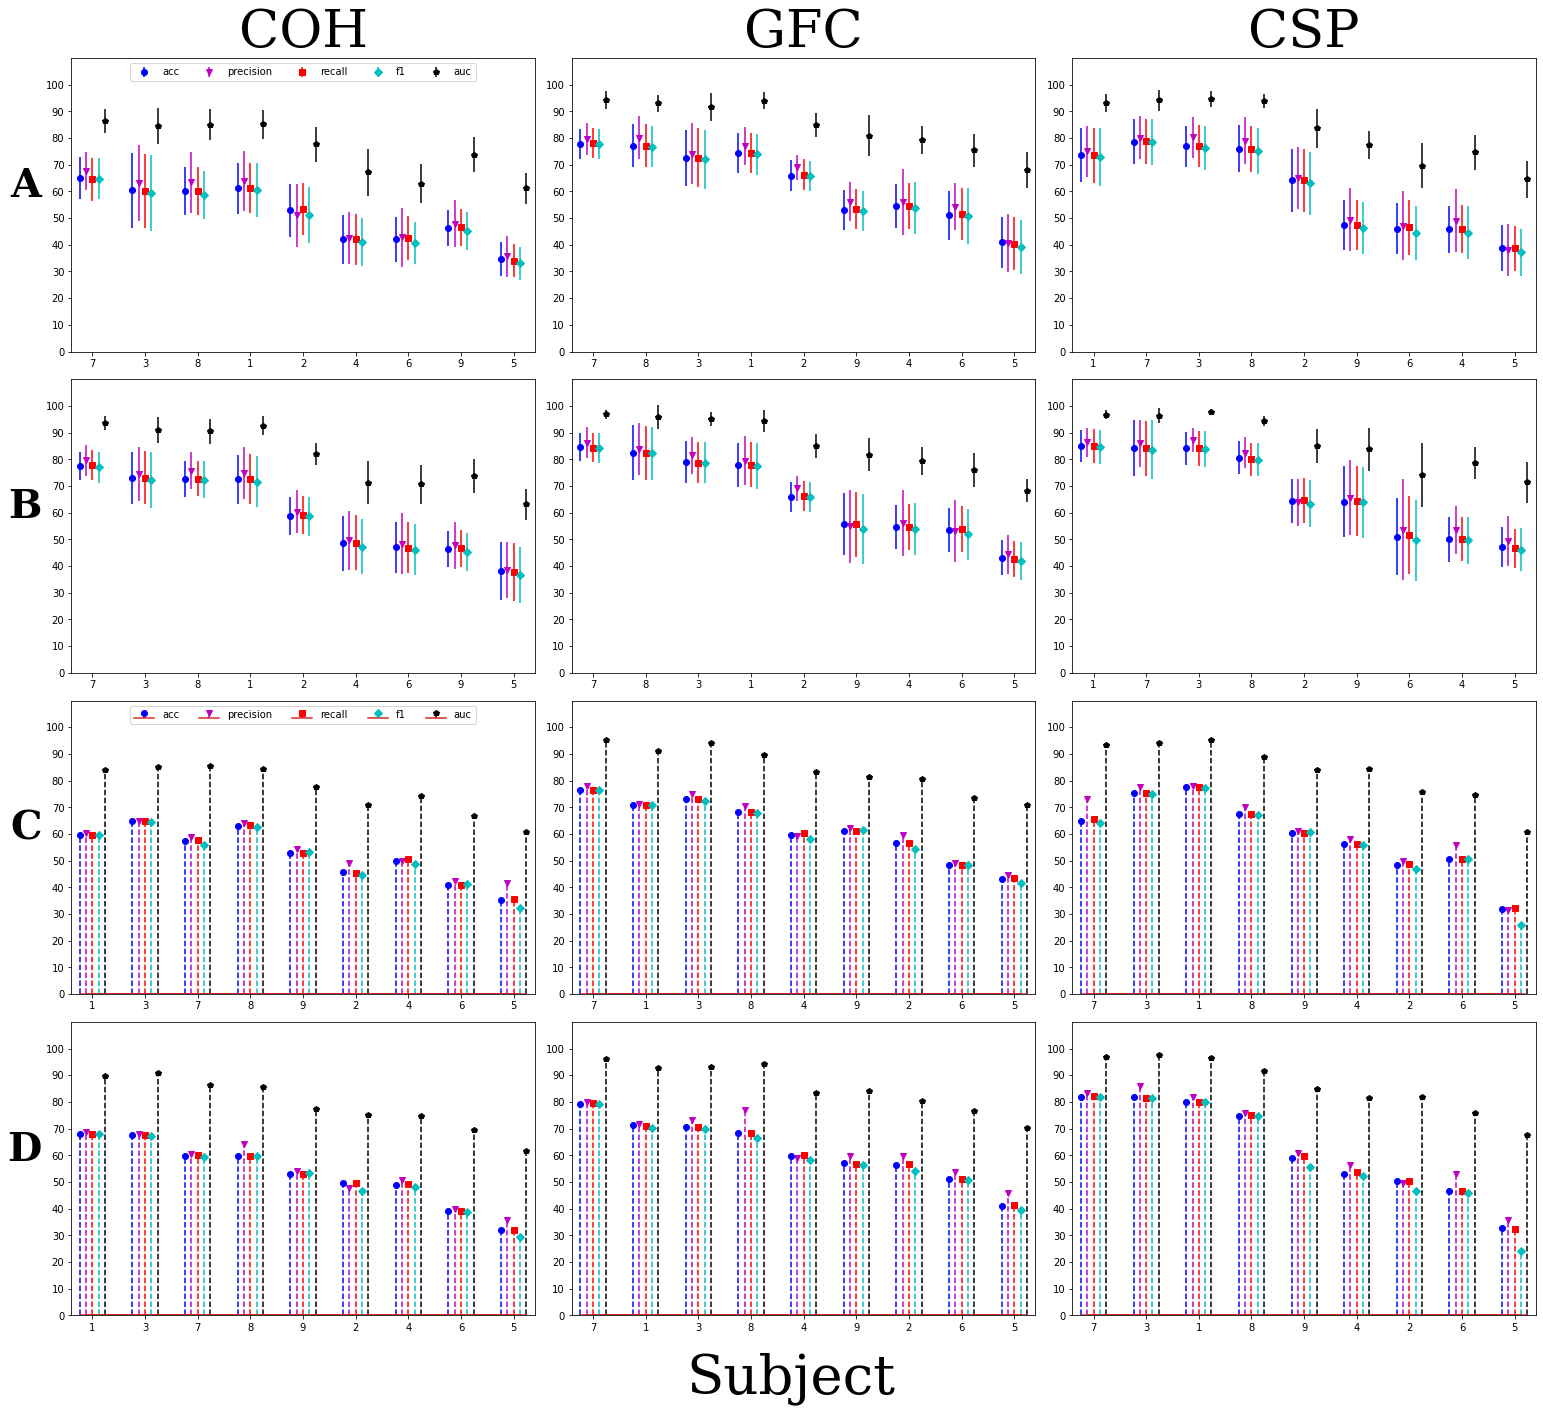

In [ ]:
evaluation_mode = ['CV/', 'test/']
type_representation = ['COH', 'GFC', 'CSP']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
subjects = np.arange(9)+1
xseed = np.array([-0.6, -0.3, 0, 0.3, 0.6])
markers = ['o', 'v', 's', 'D', 'p']
colors = ['b', 'm','r', 'c', 'k']
fig, axs = plt.subplots(len(evaluation_mode)*len(type_preprocessing), len(type_representation), figsize=(21,18), squeeze=False)

for id_eval_mode, eval_mode in zip([0,2], evaluation_mode):
  for id_type_rep, type_rep in enumerate(type_representation):
    with open(parent_dir + eval_mode + 'Multi-Class/' + type_rep + '.txt', 'rb') as feval:
      eval_info = load(feval) #Load CV info
    if eval_mode == 'CV/':
      sbjs_order = np.argsort(read_results(eval_info, mode=eval_mode, type_exp='Preprocessing', subjects=subjects)[0,0,:])[::-1]
    else:
      sbjs_order = np.argsort(read_results(eval_info, mode=eval_mode, type_exp='Preprocessing', subjects=subjects)[0,:])[::-1]
    for id_type_prep, type_prep in enumerate(type_preprocessing):
      sbjs_metrics = read_results(eval_info, mode=eval_mode, type_exp=type_prep, subjects=subjects)
      for id_m, m in enumerate(metrics):
        if eval_mode == 'CV/':
          axs[id_type_prep+id_eval_mode, id_type_rep].errorbar(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[0,id_m,sbjs_order], yerr=sbjs_metrics[1,id_m,sbjs_order], fmt=markers[id_m], color=colors[id_m], label=m)
        else:
          axs[id_type_prep+id_eval_mode, id_type_rep].stem(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[id_m,sbjs_order], linefmt='--'+colors[id_m], markerfmt=markers[id_m]+colors[id_m], label=m)
      if eval_mode == 'CV/':
        #axs[id_type_prep+id_eval_mode, id_type_rep].legend(loc='lower left', ncol=1)
        axs[id_type_prep+id_eval_mode, id_type_rep].set_ylim([0, 110])
      else:
        #axs[id_type_prep+id_eval_mode, id_type_rep].legend(loc='upper right', ncol=1)
        axs[id_type_prep+id_eval_mode, id_type_rep].set_ylim([0, 110])
      axs[id_type_prep+id_eval_mode, id_type_rep].set_yticks(np.arange(0, 110, 10))
      axs[id_type_prep+id_eval_mode, id_type_rep].set_xticks(np.arange(0, subjects.shape[0]*2.5, 2.5))
      axs[id_type_prep+id_eval_mode, id_type_rep].set_xlim([-1, (subjects.shape[0]-1)*2.5+1])
      axs[id_type_prep+id_eval_mode, id_type_rep].set_xticklabels(subjects[sbjs_order])
  axs[0, 0].legend(loc='upper center', ncol=5)
  axs[2, 0].legend(loc='upper center', ncol=5)

fig.tight_layout()
axs[0, 0].set_title('COH', fontfamily='serif', fontsize=52.5, weight=500)
axs[0, 1].set_title('GFC', fontfamily='serif', fontsize=52.5, weight=500)
axs[0, 2].set_title('CSP', fontfamily='serif', fontsize=52.5, weight=500)

axs[0, 0].set_ylabel('A', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')
axs[1, 0].set_ylabel('B', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')
axs[2, 0].set_ylabel('C', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')
axs[3, 0].set_ylabel('D', rotation=0, fontfamily='serif', fontsize=39.6, weight=1000, ha='right')

fig.text(0.5, axs[-1,-1].get_position().y0 - 0.06, 'Subject', ha='center', fontfamily='serif', fontsize=54.5, weight=500)
plt.savefig(images_dir+'metrics-subjects-multi-class.pdf',format='pdf', bbox_inches='tight')

##### Graph 2

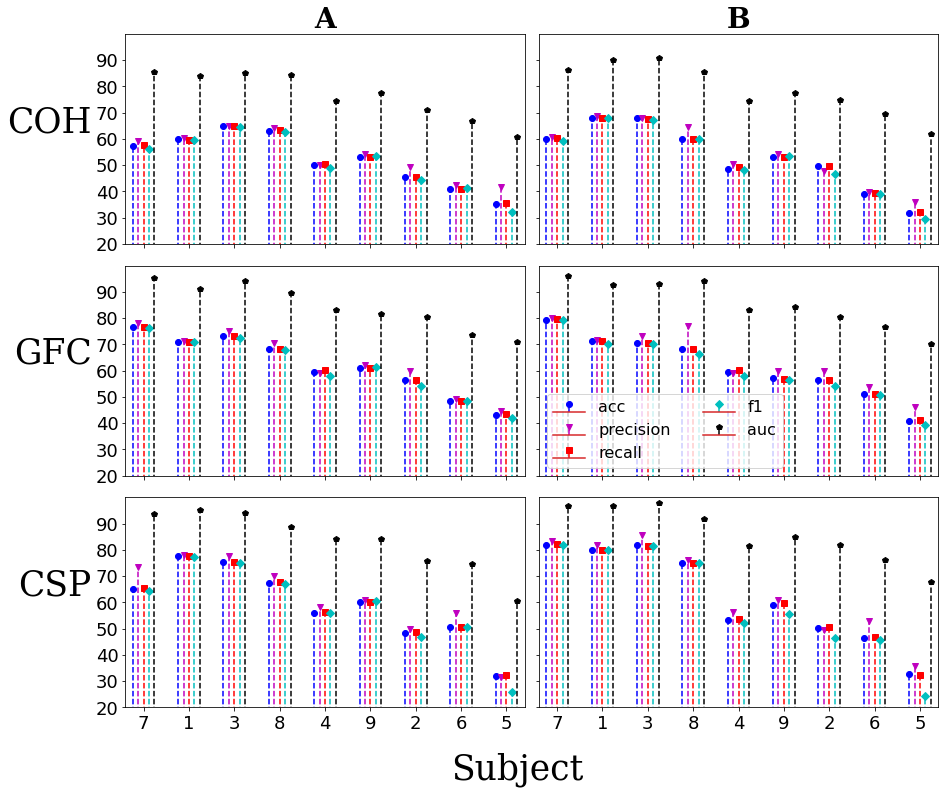

In [ ]:
type_feat_extraction = ['COH', 'GFC', 'CSP']
type_preprocessing = ['No_Preprocessing', 'Preprocessing']
metrics = ['acc', 'precision', 'recall', 'f1', 'auc']
subjects = np.arange(9)+1
min = np.inf
max = -np.inf
xseed = np.array([-0.6, -0.3, 0, 0.3, 0.6])
markers = ['o', 'v', 's', 'D', 'p']
colors = ['b', 'm','r', 'c', 'k']
fig, axs = plt.subplots(len(type_feat_extraction), len(type_preprocessing), figsize=(12,10), squeeze=False, sharex=True, sharey=True)

with open(test_dir + 'GFC.txt', 'rb') as feval:
  eval_info = load(feval) #Load test info
sbjs_order = np.argsort(read_results(eval_info, mode='test/', type_exp='Preprocessing', subjects=subjects)[0,:])[::-1]

for id_type_fte, type_fte in enumerate(type_feat_extraction):
  with open(test_dir + type_fte + '.txt', 'rb') as feval:
    eval_info = load(feval) #Load test info
  for id_type_prep, type_prep in enumerate(type_preprocessing):
    sbjs_metrics = read_results(eval_info, mode='test/', type_exp=type_prep, subjects=subjects)
    if sbjs_metrics.min() < min:
      min = sbjs_metrics.min()
    if sbjs_metrics.max() > max:
      max = sbjs_metrics.max()
    for id_m, m in enumerate(metrics):
      axs[id_type_fte, id_type_prep].stem(np.arange(0, subjects.shape[0]*2.5, 2.5)+xseed[id_m], sbjs_metrics[id_m,sbjs_order], linefmt='--'+colors[id_m], markerfmt=markers[id_m]+colors[id_m], label=m)
      
for j in range(axs.shape[1]):
  axs[-1,j].set_xticks(np.arange(0, subjects.shape[0]*2.5, 2.5))
  axs[-1,j].set_xticklabels(subjects[sbjs_order], fontsize=18)
  axs[-1,j].set_xlim([-1, (subjects.shape[0]-1)*2.5+1])

#Becareful with the order
for i in range(axs.shape[0]):
  axs[i,0].set_ylim([rounddown(min), roundup(max)])

for i in range(axs.shape[0]):
  axs[i,0].set_yticks(np.arange(rounddown(min), roundup(max), 10, dtype=np.int))
  axs[i,0].set_yticklabels(np.arange(rounddown(min), roundup(max), 10, dtype=np.int), fontsize=18)

axs[1,1].legend(loc='lower left', fontsize=16, ncol=2)

fig.tight_layout()
axs[0, 0].set_ylabel('COH', fontfamily='serif', fontsize=34.5, weight=500, rotation=0, ha='right')
axs[1, 0].set_ylabel('GFC', fontfamily='serif', fontsize=34.5, weight=500, rotation=0, ha='right')
axs[2, 0].set_ylabel('CSP', fontfamily='serif', fontsize=34.5, weight=500, rotation=0, ha='right')

axs[0, 0].set_title('A', fontfamily='serif', fontsize=28, weight=1000)
axs[0, 1].set_title('B', fontfamily='serif', fontsize=28, weight=1000)

fig.text(0.5, axs[-1,-1].get_position().y0 - 0.1, 'Subject', ha='center', fontfamily='serif', fontsize=34.5, weight=500)
plt.savefig(images_dir+'metrics-subjects-multi-class.pdf',format='pdf', bbox_inches='tight')